In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

## Read data

In [18]:
df = pd.read_csv('data/final_data/balanced_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41326 entries, 0 to 41325
Columns: 112 entries, TransactionID to isFraud
dtypes: float64(105), int64(7)
memory usage: 35.3 MB


In [19]:
df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,isFraud
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


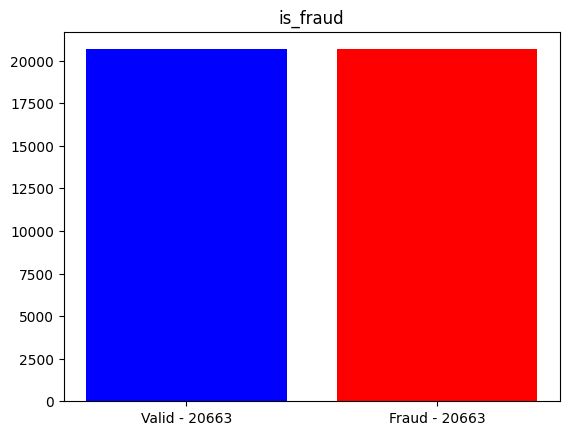

In [20]:
plt.rcdefaults()
# obtain ground truth from train column
is_fraud = df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('is_fraud')
plt.savefig('graphs/train_barplot.png')
plt.show()

## Divide the data into training, validation and test data and prepare for model training

### Divide data into train_df and test_df

In [36]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()


counter = 0

for label in df['isFraud'].unique():
    label_data = df[df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    
    split_index = int(0.8 * len(label_data))
    if counter != 0:
        train_df = pd.concat([train_df, label_data[:split_index]])
        test_df = pd.concat([test_df, label_data[split_index:]])
    else:
        train_df = label_data[:split_index]
        test_df = label_data[split_index:]
        
    counter += 1
    
print(f'len(train_df) = {len(train_df)}')
print(f'len(test_df) = {len(test_df)}')

len(train_df) = 33060
len(test_df) = 8266


#### View the distribution of classes in train and test data

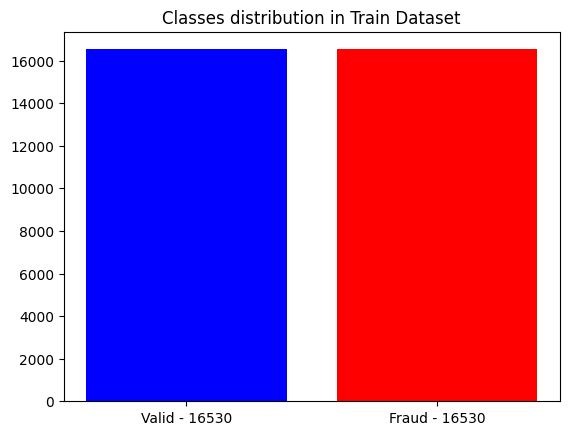

In [38]:
plt.rcdefaults()
# obtain ground truth from train column
is_fraud = train_df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('Classes distribution in Train Dataset')
plt.savefig('graphs/train_barplot.png')
plt.show()

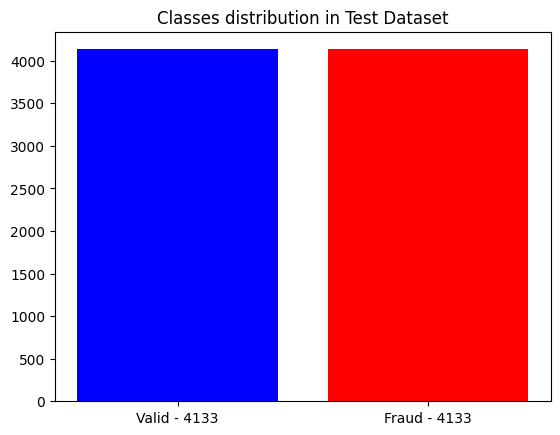

In [39]:
# obtain ground truth from train column
is_fraud = test_df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('Classes distribution in Test Dataset')
plt.savefig('graphs/test_barplot.png')
plt.show()

### Divide train_df into X_train, y_train, X_valid, y_valid

In [41]:
X_train = pd.DataFrame()
y_train = []

X_valid = pd.DataFrame()
y_valid = []

counter = 0

for label in train_df['isFraud'].unique():
    label_data = train_df[train_df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    split_index = int(0.8 * len(label_data))
    
    if counter != 0:
        X_train = pd.concat([X_train, label_data[label_data.columns[:-1]][:split_index]])
        X_valid = pd.concat([X_valid, label_data[label_data.columns[:-1]][split_index:]])
    else:
        X_train = label_data[label_data.columns[:-1]][:split_index]
        X_valid = label_data[label_data.columns[:-1]][split_index:]
        
    y_train.extend(list(label_data['isFraud'].values[:split_index]))
    y_valid.extend(list(label_data['isFraud'].values[split_index:]))
    counter += 1
    
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

len(X_train) = 26448
len(y_train) = 26448
len(X_valid) = 6612
len(y_valid) = 6612


### Divide test_df into X_test and y_test

In [45]:
X_test = test_df[test_df.columns[:-1]]
y_test = test_df['isFraud'].values
len(X_test)

8266

### View the distribution of classes in train, validation and test data

In [46]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'\nlen(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'\nlen(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 26448
len(y_train) = 26448

len(X_valid) = 6612
len(y_valid) = 6612

len(X_test) = 8266
len(y_test) = 8266


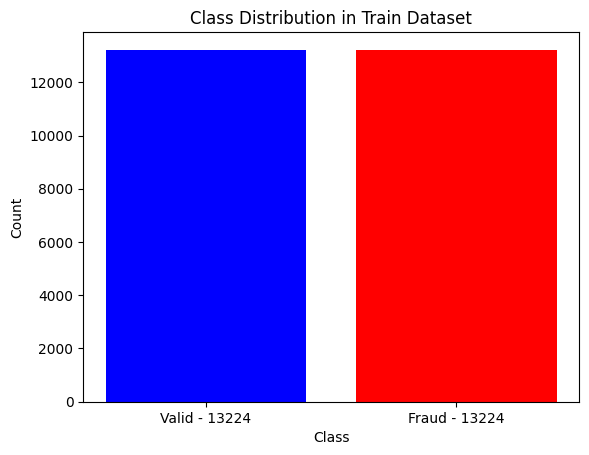

In [49]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_train) == 0)
num_fraud_train = len(y_train) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Train Dataset')
plt.savefig('graphs/train_barplot.png')
plt.show()

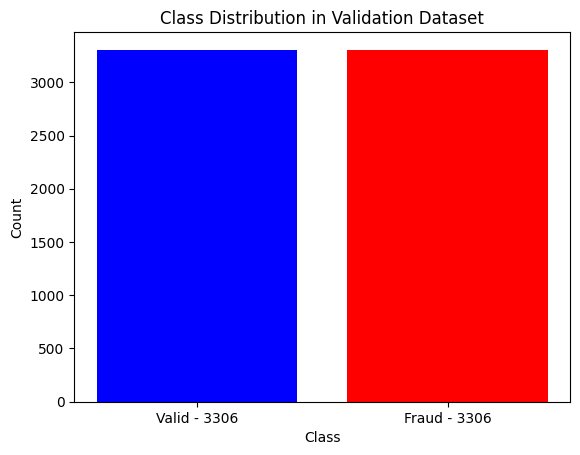

In [50]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_valid) == 0)
num_fraud_train = len(y_valid) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Validation Dataset')
plt.savefig('graphs/validation_barplot.png')
plt.show()

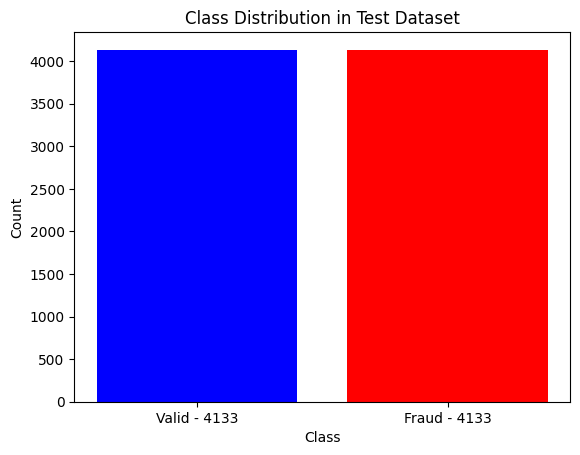

In [51]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_test) == 0)
num_fraud_train = len(y_test) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Dataset')
plt.savefig('graphs/test_barplot.png')
plt.show()